In [22]:
!python -m pip install numpy scipy matplotlib PyWavelets

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.optimize import linprog, milp, Bounds, LinearConstraint

# Background

Compressed Sensing (CS, also known as "Compressive Sensing") refers to a set of sparse signal processing techniques for reconstructing signals that have been sampled well-under the Nyquist rate.  Many image processing and reconstruction applications greatly benefit from faster acquisitions (with potentially more computationally expensive post-processing requirements).  Many natural images and signals including those in Magnetic Resonance Imaging and astronomy are sparse (they have few non-zero values) either latently or when transformed into another domain ([Sparse MRI](https://pubmed.ncbi.nlm.nih.gov/17969013/), [Astronomy](https://arxiv.org/abs/0802.0131)).  Wavelet, Discrete Cosine, and finite differences are common transforms that can produce sparse representations of images and signals.  [JPEG compression](https://en.wikipedia.org/wiki/JPEG_2000) also takes advantage of the fact that many images are sparse in wavelet domains:

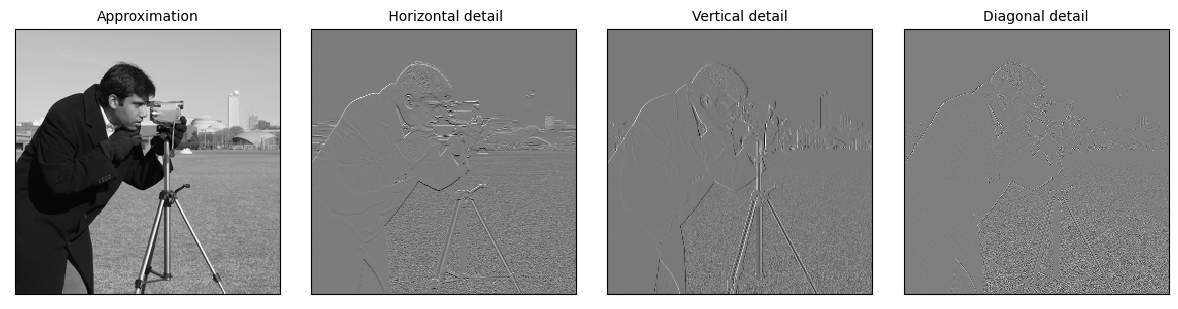

In [24]:
# example from PyWavelet's documentation: https://pywavelets.readthedocs.io/en/latest/
import pywt
import pywt.data

# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Above, you can see that most non-zero coefficients are concentrated in the initial approximation and few coefficients are needed to represent directional details.  In fact, looking at the sorted coefficient magnitudes, we see that the "energy" of the image is concentrated on the right-hand side with many approximately-zero coefficients on the left:

([], [])

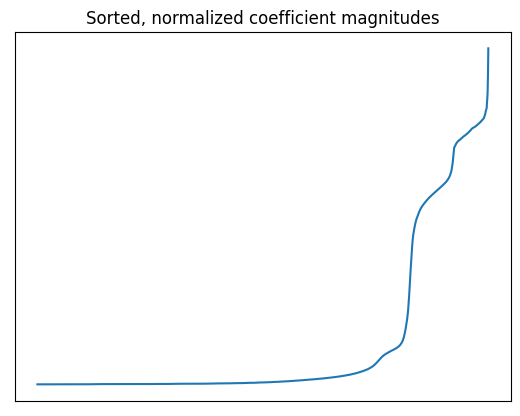

In [25]:
all_coefficients = np.concatenate((LL, LH, HL, HH))
mag = np.abs(all_coefficients.flatten())
mag /= np.max(mag)

plt.plot(np.sort(mag))
plt.title("Sorted, normalized coefficient magnitudes")
plt.xticks([])
plt.yticks([])

CS was introduced into many domains to combat the trade off between the time it takes to measure signals and resolution. It grew out of the pioneering work of Candes, Romberg, Tao, and Donoho, who demonstrated that n-dimensional signals with sparse representations can be reconstructed from a set of linear, non-adaptive measurements (non-adaptive in the sense that we don't change anything about the sensor or data acquisiton based on what we measure) (e.g., [Candes, Romberg, Tao](https://ieeexplore.ieee.org/document/1580791)). They showed that in a wide variety of cases, reconstructions can exactly recover the desired signal using far fewer measurements than could otherwise be done by assuming some sparsity requirements.

CS differs from classical Nyquist sampling theory in a few important ways (see [Eldar et al](https://books.google.com/books/about/Compressed_Sensing.html?id=Gm3ihcJwN0YC)):
- Classical sampling theory usually considers infinite dimensional, continuous-time signals while CS is usually restricted to `n`-dimensional signals
- CS formulations usually do not sample the signal at specific, periodic points in time as is done classically.  Measurements also typically include some tactically random components
- Classical formulations rely on sinc interpolation, whereas CS signal reconstruction is often relies on non-linear reconstruction and interpolation methods

# Problem

Formally, CS can be understood as a method of finding an exact (or close) solution to the highly under-determined system:

$$ Ax = b $$

with $A$ being an $M \times N$ matrix such that $M \ll N$.

Often we can solve inverse problems using a psuedonorm (i.e., $\hat{x} = A^{-1}b$) as long as $A$ is full rank:

([], [])

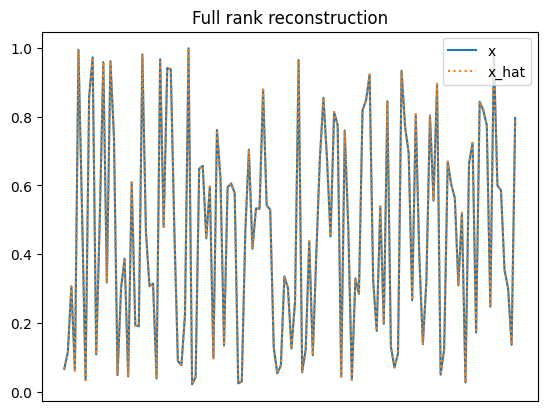

In [26]:
A = np.random.normal(loc=0, scale=1, size=(128, 128))
x = np.random.rand(128)
b = A @ x

x_hat = np.linalg.solve(A, b)

plt.plot(x, label="x")
plt.plot(x_hat, ":", label="x_hat")
plt.legend()
plt.title("Full rank reconstruction")
plt.xticks([])

However, we run into issues when $A$ is not full rank.  $A$ in the CS problem is a "short, fat" matrix while $x$ is a "tall" vector.  $b$ here are the measurements we acquire, so it should also be short:

    ______________________________  _     _
    |                            | | | = | |
    |              A             | |x|   |b|
    |____________________________| | |   |_|
                                   | |
                                   | |
                                   | |
                                   | |
                                   |_|
                                   
We can't use `np.linalg.solve()` in this case (it will complain about non-square $A$!), but we can try to find the least-squares solution to the system:

([], [])

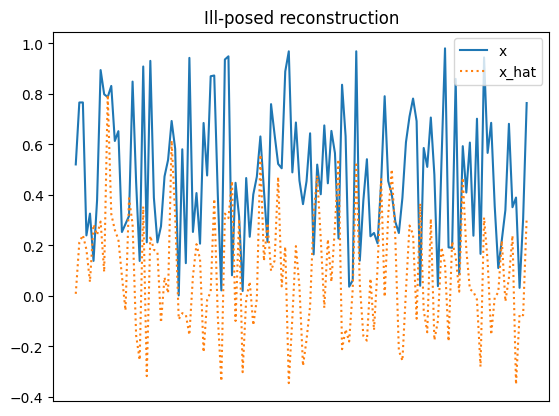

In [27]:
M, N = 20, 128
A = np.random.normal(loc=0, scale=1, size=(M, N))
x = np.random.rand(N)
b = A @ x

x_hat = np.linalg.lstsq(A, b, rcond=None)[0]

plt.plot(x, label="x")
plt.plot(x_hat, ":", label="x_hat")
plt.legend()
plt.title("Ill-posed reconstruction")
plt.xticks([])

Unfortunately (and as expected), the approximation $\hat{x}$ is not very good.

To solve the issues of ill-posedness of the inverse problem and find a unique solution, we can regularize the system by imposing sparsity through an abuse of notation with the $\ell_0$ pseudo-norm in the constrained, highly non-convex optimization problem:

$$ \min_{\forall x} || x ||_0 \text{ subject to } Ax = b$$

We assume the matrix $A$ (sometimes called the "sensing matrix") samples the signal randomly or pseudo-randomly. It must in fact satisfy certain criteria for the inverse problem above to be solvable via linear and mixed integer linear programming. Although there are a number of ways to say that $A$ "has the right properties", the most common is the restricted isometry property (RIP) (see [Candes](https://www.sciencedirect.com/science/article/pii/S1631073X08000964)). If $A$ satisfies the RIP, then the CS problem is well defined.

Unfortunately, verifying that $A$ does indeed satisfy the restricted isometry condition is NP-hard and not in the scope of this tutorial. Usually $A$ is chosen to be something we know does satisfy or with high probability satisfies the RIP (e.g., matrices with independent and identically distributed Gaussian or Bernoulli entries). This is a humorous result: the randomness of $A$ is [too important to be left up to chance](https://en.wikipedia.org/wiki/Robert_Coveyou).

There are two ways to approach this optimization problem:
  1. try really hard to solve the problem as posed
  2. relax the problem to an easier one that we have better tools to solve

We will try both of those approaches in this tutorial, first starting with the relaxed form.

To make things concrete, for the linear programming example, we'll assume $A \sim N(0, 1)$ and $x$ is an integer valued $k$-sparse signal (i.e., only $k$ coefficients are non-zero):

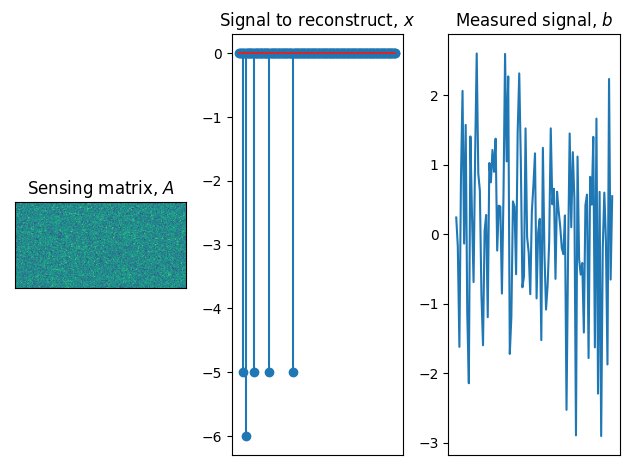

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

M = 100  # number of measurements
N = 200  # signal length
k = 5  # number of non-zero elements

# generate a random measurement matrix (normal), normalize columns; satisfies RIP
A = np.random.randn(M, N)
A /= np.sqrt(np.sum(A**2, axis=0))

ax1.imshow(A)
ax1.set_title("Sensing matrix, $A$")
ax1.set_xticks([])
ax1.set_yticks([])

# sparse integer-valued signal, x
x = np.sign(np.random.rand(k) - 0.5)
x = np.append(x, np.zeros(N - k))
np.random.shuffle(x)
x *= np.random.randint(low=5, high=10, size=x.shape)

ax2.stem(x)
ax2.set_title("Signal to reconstruct, $x$")
ax2.set_xticks([])

# simulate measurement according to A
b = A @ x

ax3.plot(b)
ax3.set_title("Measured signal, $b$")
ax3.set_xticks([])

plt.tight_layout()
plt.show()

# Linear Programming Solution

As noted above, the optimization problem as posed is extremely difficult to solve.  In fact, incorporating the $\ell_0$ quasi-norm is known to be NP-hard (and for any fixed $L_p$ norm ($0 < p < 1$), finding the global minimum of the problem is strongly NP-hard, see [Ye](https://web.stanford.edu/~yyye/lpmin_v14.pdf)). Nearly all practical CS algorithms and implementations will substitute the $\ell_0$ quasi-norm with its more tractable convex relaxation using the $\ell_1$ norm (e.g., [Donoho](https://www.sciencedirect.com/science/article/abs/pii/S0165168405002203)):

$$ \min_{\forall x} || x ||_1 \text{ subject to } Ax = b$$

This leads to favorable forms of solutions and algorithms for the class of L1-regularized problems that can be solved using linear programming (including [basis pursuit](http://www-leland.stanford.edu/group/SOL/papers/BasisPursuit-SIGEST.pdf), [basis pursuit denoising](https://arxiv.org/pdf/0910.1623.pdf), and [LASSO algorithms](https://www.jstor.org/stable/2346178)).  Let's walk through converting the optimization problem above to a linear program.

First, $|| x ||_1$ can written as a summation:

$$ || x ||_1 = \sum_i | x_i | $$

Because we want the absolute value of each $x_i$, we need to introduce auxiliarly variables $t_i$.  We want $|x_i| \leq t_i$, or written another way: $x_i < t_i$ and $-x_i < t_i$. This leads to:

$$ \sum_i | x_i | \leq \sum_i t_i $$

Thus if we minimize $\sum_i t_i $, then we are also minimizing $\sum_i | x_i |$ (which is what we wanted!).  So we can write the linear programming coefficients $c$ to optimize over decision variables $z = [ x, t ]$ as:

$$ c = [ 0_{1 \times N}, 1_{1 \times N} ] $$

so that

$$ c^T z = 0^T x + 1^T t = \sum_i t_i = || x ||_1 $$


In [29]:
c = [0]*N + [1]*N

Now that we have the objective function, let's encode the $|x_i| \leq t_i$ constraint in the `A_ub` matrix.  Upper-bound constraints are written in the form $\leq 0$, so $|x_i| - t_i \leq 0$ expands to:

$$ x_i - t_i \leq 0 $$
$$ -x_i - t_i \leq 0 $$

Or equivalently in matrix form (using $I$ for $N \times N$ identity matrices and $0$ for $1 \times N$ all-zero vectors):

$$
A_{\text{ub}} z =
\begin{bmatrix}
I & -I \\
-I & -I
\end{bmatrix}
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq
\begin{bmatrix}
0 \\
0
\end{bmatrix}
= b_{\text{ub}}
$$

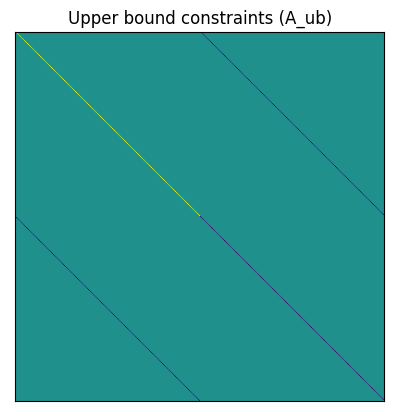

In [30]:
A_ub = csc_matrix((2*N, 2*N))
for ii in range(N):
    A_ub[ii, ii] = 1
    A_ub[ii+N, ii] = -1
    A_ub[ii, ii+N] = -1
    A_ub[ii+N, ii+N] = -1
    
plt.imshow(A_ub.toarray())
plt.title("Upper bound constraints (A_ub)")
plt.xticks([])
plt.yticks([])
plt.show()

b_ub = np.zeros(2*N)

Also note the bounds of the variables $x_i$ and $t_i$: $x_i$ may assume any value while $t_i$ is restricted to be $\geq 0$ (as it's always greater than or equal to the absolute value of $x_i$).  We can give this information to the solver in the form of bounds:

$$
\begin{bmatrix}
-\infty \\
0
\end{bmatrix}
\leq
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq
\begin{bmatrix}
\infty \\
\infty
\end{bmatrix}
$$

In [31]:
#              x_i bounds         t_i bounds
bounds = [(-np.inf, np.inf)]*N + [(0, np.inf)]*N

Now that we have all the machinery in place to compute the $|| x ||_1$ term, the last part is ensuring the data fidelity clause: "subject to $Ax = b$".  Taking into account that $z = [ x, t ]$, we can write this in matrix form:

$$
A_{\text{eq}} z =
\begin{bmatrix}
A & 0
\end{bmatrix}
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq b = b_{\text{eq}}
$$

In [32]:
A_eq = csc_matrix((M, 2*N))
A_eq[:, :N] = A
b_eq = b

Now we are ready to solve the entire linear program:

$$
\min_{\forall x, t} || t ||_1 \\
\begin{bmatrix}
-\infty \\
0
\end{bmatrix}
\leq
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq
\begin{bmatrix}
\infty \\
\infty
\end{bmatrix} \\
\begin{bmatrix}
A & 0
\end{bmatrix}
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq b \\
\begin{bmatrix}
I & -I \\
-I & -I
\end{bmatrix}
\begin{bmatrix}
x \\
t
\end{bmatrix}
\leq
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

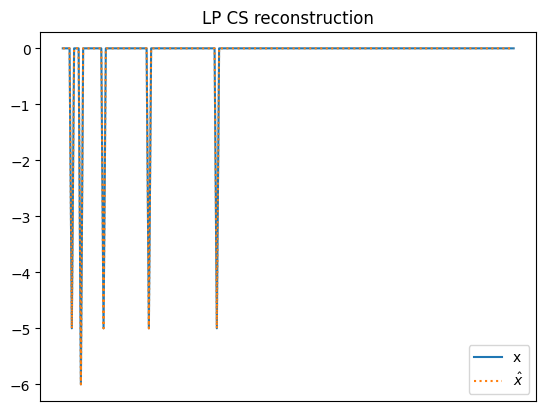

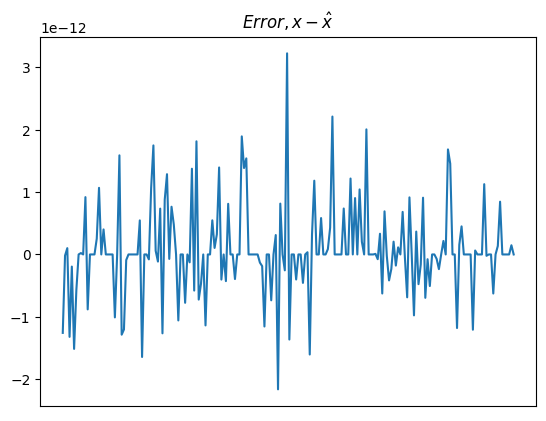

In [33]:
res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
x_hat = res.x[:N]

plt.plot(x, label="x")
plt.plot(x_hat, ":", label="$\hat{x}$")
plt.legend()
plt.title("LP CS reconstruction")
plt.xticks([])
plt.show()

plt.plot(x - x_hat)
plt.title("$Error, x - \hat{x}$")
plt.xticks([])
plt.show()

# Integer Constraints

We may know a priori that our signal should be integer-valued or belong to a discrete set of possibilities (e.g., appropriately scaled voltages in digital communications).  In this case, we can add integral constraints to the linear program to transform it into a mixed integer linear program and solve it using `scipy.optimize.milp`.

From our example above, we now assume we know that $x_i$ are integers.  This amounts to adding an `integrality` argument to `milp` for both $x_i$ and $t_i$ (since the absolute value of an integer is also an integer):

In [34]:
# 0 -> continuous variable, 1 -> integer-valued variable
integrality=[1]*(2*N)

The other two change we need to make are converting the matrix style constraints `A_ub`/`b_ub` and `A_eq`/`A_eq` to `scipy.optimize.LinearConstraint`s and `linprog`-style bounds to a `scipy.optimize.Bounds` object.

The constraint mapping is simply representing a lower bound constraint as a two-sided inequality:

$$ A_{\text{eq}} z = b_{\text{eq}} \implies b_{\text{eq}} \leq A_{\text{eq}} \leq b_{\text{eq}} $$
$$ A_{\text{ub}} z \leq b_{\text{ub}} \implies -\infty \leq A_{\text{ub}} \leq b_{\text{ub}} $$

In [35]:
constraints = [
    LinearConstraint(A=A_eq, lb=b_eq, ub=b_eq),
    LinearConstraint(A=A_ub, lb=-np.inf, ub=b_ub),
]

milp_bounds = Bounds(lb=[lb for lb, ub in bounds], ub=[ub for lb, ub in bounds])

Now we can pass the same coefficients and repackaged constraints and bounds to the SciPy MILP solver as well as the types of the decision variables (all integer in this case).  I will pass in the option `"disp": True` to see the progress of the solver.

Running HiGHS 1.2.2 [date: 2022-08-26, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
500 rows, 400 cols, 20800 nonzeros
500 rows, 400 cols, 20636 nonzeros
Objective function is integral with scale 1

Solving MIP model with:
   500 rows
   400 cols (0 binary, 400 integer, 0 implied int., 0 continuous)
   20636 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.1s
 T       0       0         0   0.00%   0               26               100.00%        0      0      0       239     0.1s

Solving report
  Status            Optimal
  Primal bound      26
  Dual bound        26
  Gap               0% (tolerance: 0.01%)
  Solution status  

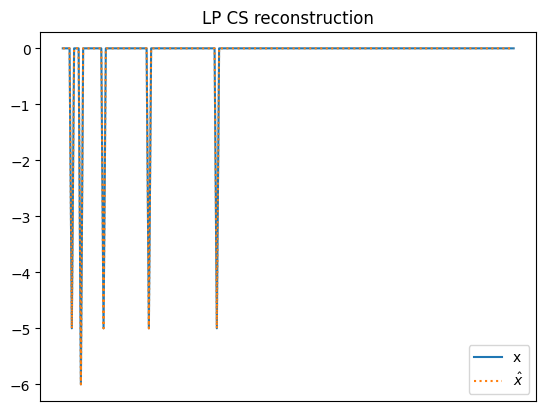

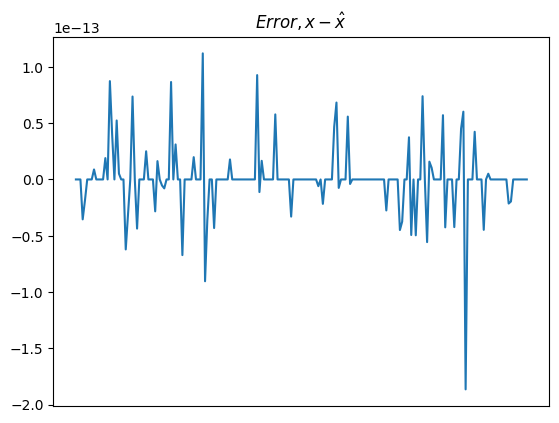

In [36]:
res = milp(c=c, integrality=integrality, constraints=constraints, bounds=milp_bounds, options={"disp": True})
x_hat = res["x"][:N]

plt.plot(x, label="x")
plt.plot(x_hat, ":", label="$\hat{x}$")
plt.legend()
plt.title("LP CS reconstruction")
plt.xticks([])
plt.show()

plt.plot(x - x_hat)
plt.title("$Error, x - \hat{x}$")
plt.xticks([])
plt.show()

Unsurprisingly we see very similar performance as before, but now we are sure that the reconstructed signal has an integer-valued solution!